# <center> Projet 10: Détectez des faux billets avec R ou Python </center>

# Sommaire :
 - <a href="#C1">Importation des données</a>
 - <a href="#C2">Analyse des données</a>
 - <a href="#C3">Régression linéaire</a>
 - <a href="#C4">ACP</a>
 - <a href="#C6">K-Means</a>
 - <a href="#C5">Régression logistique</a>
 
 
 
# <a name="C1">Importation des données</a>

In [1]:
from fonctions import *

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27),
            'axes.titlesize': 'x-large'})
color_blue = '\033[94m'
color_reset = '\033[0m'

In [3]:
billet = pd.read_csv('billets.csv', sep=";", decimal=".")

# <a name="C2">Analyse des données</a>

In [4]:
analyse_primaire(billet)

head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


dtypes


is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

shape


(1500, 7)

describe(describe = 'all')


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


On peut voir qu'il y a des données manquantes sur la variable "margin_low", le jeu de données n'est pas équilibré. 

In [5]:
Imbalance_ratio = 1000/500
print(f"Nous pouvons calculer l'Imbalance ratio afin de voir à quel point nos données sont déséquilibrées.\n{color_blue}Imbalance ratio = {Imbalance_ratio}{color_reset}")

Nous pouvons calculer l'Imbalance ratio afin de voir à quel point nos données sont déséquilibrées.
Imbalance ratio = 2.0


Regardons maintenant plus en détail les données manquantes sur "margin_low".

In [6]:
billet.isna().mean()

is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

In [7]:
#Répartition des valeurs manquantes par type de billets.
billet.loc[billet["margin_low"].isna(),["is_genuine", "margin_low"]].groupby(by="is_genuine", dropna=False).size()

is_genuine
False     8
True     29
dtype: int64

On remarque qu'il y a des données manquantes pour margin_low que ce soit pour des billets vrais ou des billets faux. Nous pouvons regarder via des boîtes à moustaches s'il y a une différence entre les vrais et faux billets pour chaque variable.

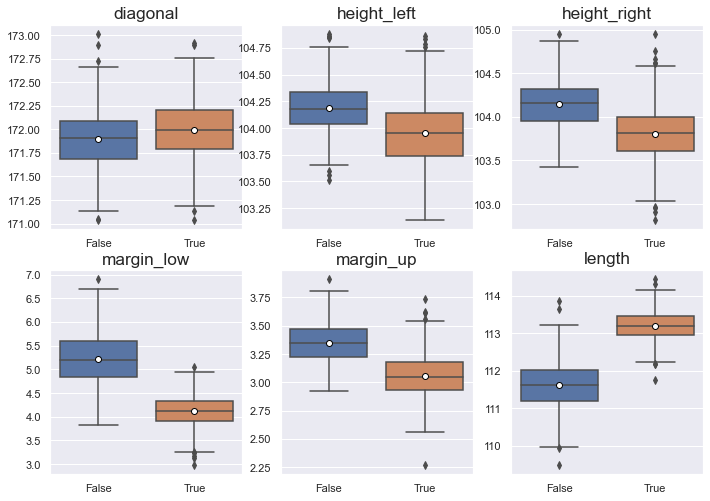

In [8]:
x=231

for i in range(billet.shape[1] - 1): #-1 car la colonne is_guenine ne doit pas passer en y
    plt.subplot(x)
    sns.boxplot(data=billet,
                    x="is_genuine", 
                    y=billet.columns[i + 1],
                    showmeans = True,
                    meanprops = {"marker" : "o",
                                 "markerfacecolor" : "white",
                                 "markeredgecolor" : "black"},
                    showfliers = True);
    plt.title(billet.columns[i + 1])
    plt.xlabel("")
    plt.ylabel("")
    x += 1

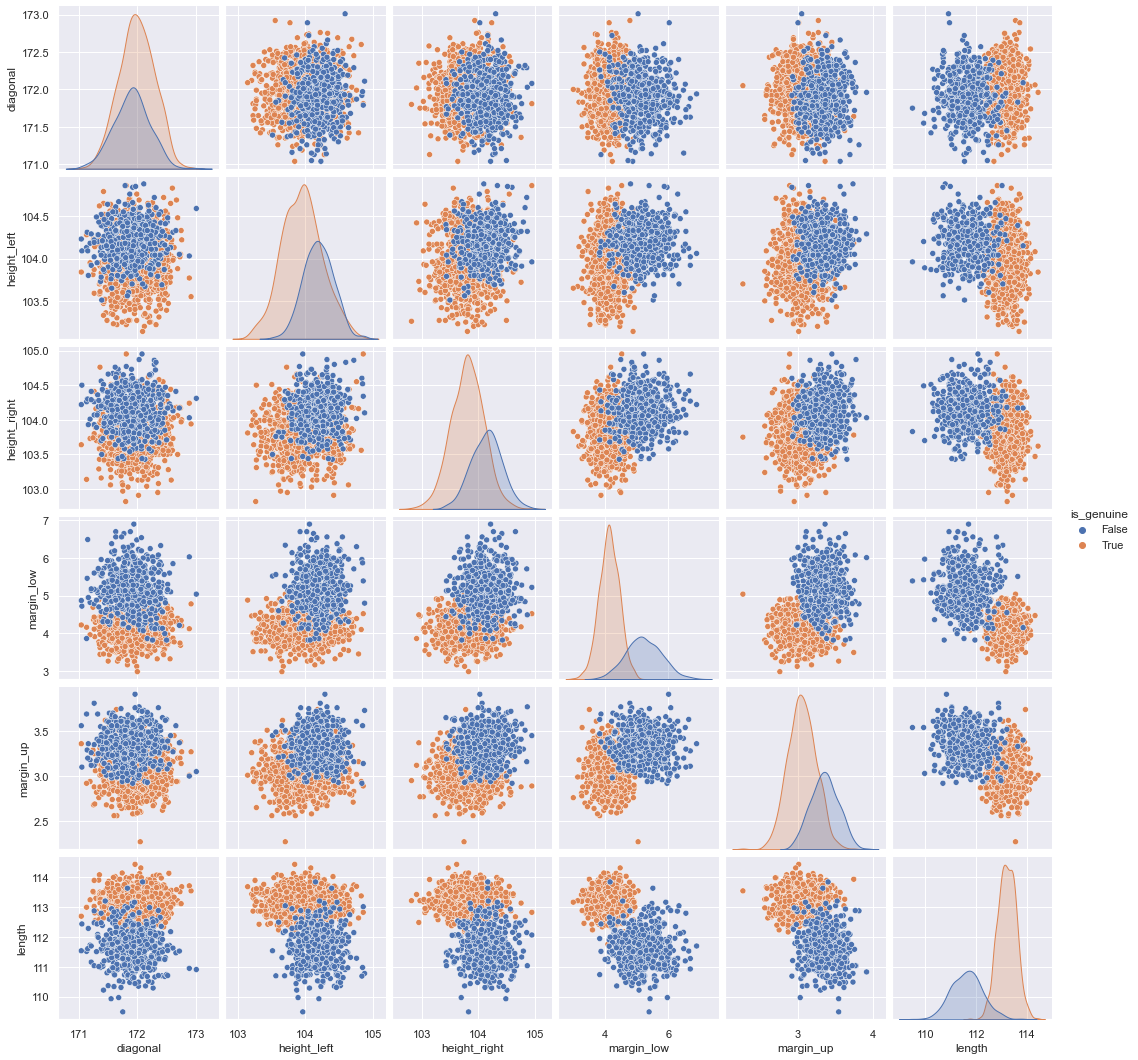

In [9]:
sns.pairplot(billet, hue="is_genuine");

On remarque une plus grande différence avec les variables "margin_low" et "length".  
Intéressons-nous maintenant plus à la variable "margin_low".

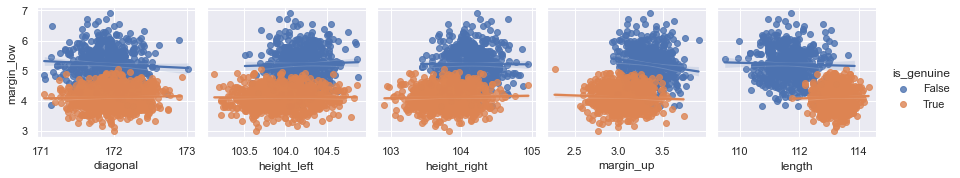

In [10]:
sns.pairplot(billet, x_vars=['diagonal', 'height_left', 'height_right', 'margin_up', 'length'], y_vars= 'margin_low', kind='reg', hue="is_genuine");

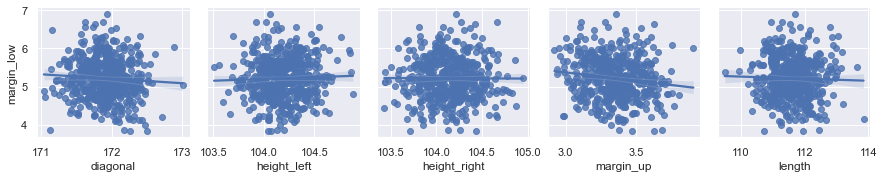

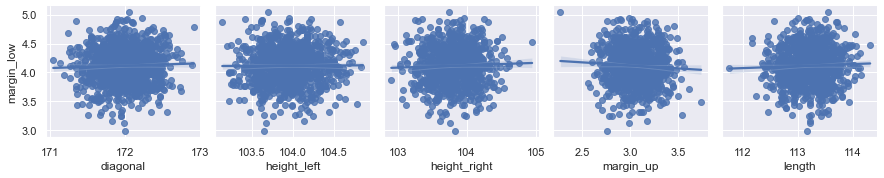

In [11]:
for i in range(2):
    sns.pairplot(billet.loc[billet["is_genuine"]==i,], x_vars=['diagonal', 'height_left', 'height_right', 'margin_up', 'length'], y_vars= 'margin_low', kind='reg');

# <a name="C3">Régression linéaire</a>  
Afin d'imputer les données manquantes à margin_low, nous allons utiliser une régression linéaire.

In [12]:
model = billet.copy()
model = model.loc[~model["margin_low"].isna()]

model_train, model_test = train_test_split(model, random_state = 0, test_size=0.2)

In [13]:
reg = smf.ols("margin_low~diagonal+height_left+height_right+margin_up+length+is_genuine", data = model_train).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     314.0
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          3.69e-239
Time:                        20:03:28   Log-Likelihood:                -604.92
No. Observations:                1170   AIC:                             1224.
Df Residuals:                    1163   BIC:                             1259.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              6.9022      9

Soupçon de multicolinéarité entre nos variables explicatives. Cependant, vérifions tout d'abord la colinéarité de nos variables.

In [14]:
variables = reg.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[4.731236415236333,
 1.029490519281078,
 1.1741749787163689,
 1.3262797662028147,
 1.6204659718851568,
 3.585225352607611]

Il n'y a pas de problème de colinéarité entre nos variables car les coefficients sont tous inférieur à 10.  
La méthode la plus simple pour traiter le problème de multicolinéarité est de supprimer la variable la moins significative du modèle. Nous allons pour cela utiliser une méthode "backward" qui supprimera la variable la moins significative à chaque itération du modèle.

In [15]:
reg = backward_selected(model_train, "margin_low")

_______________________________
margin_low ~ is_genuine + length + diagonal + height_right + height_left + margin_up + 1
remove height_right (p-value : 0.678 )

_______________________________
margin_low ~ is_genuine + length + diagonal + height_left + margin_up + 1
remove length (p-value : 0.612 )

_______________________________
margin_low ~ is_genuine + diagonal + height_left + margin_up + 1
remove height_left (p-value : 0.382 )

_______________________________
margin_low ~ is_genuine + diagonal + margin_up + 1
remove diagonal (p-value : 0.253 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     942.0
Date:                Thu, 01 Sep 2

Maintenant que nous avons sélectionné notre modèle, nous allons vérifier les hypothèses des MCO.

## Vérifions l'homoscédasticité:

In [16]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 9.59143370361612e-25


P-value < 0.05: Rejet de H0, le test de Breusch Pagan nous indique qu'il y a de l'hétéroscédasticité, réalisons un test de White pour confirmer cela.

In [17]:
_, pval, __, f_pval =statsmodels.stats.diagnostic.het_white(reg.resid, variables)
print('p value test White:', pval)

p value test White: 5.16307091833536e-19


Le test de White nous indique également qu'il y a un problème d'hétéroscédasticité. Afin de corriger ce problème, nous allons prendre l'inverse de margin_low.

In [18]:
model_train["inverse_margin_low"] = 1/(model_train["margin_low"])

reg = smf.ols("inverse_margin_low~margin_up+is_genuine", data = model_train).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:     inverse_margin_low   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     837.0
Date:                Thu, 01 Sep 2022   Prob (F-statistic):          3.37e-226
Time:                        20:03:28   Log-Likelihood:                 2928.0
No. Observations:                1170   AIC:                            -5850.
Df Residuals:                    1167   BIC:                            -5835.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1752      0

In [19]:
reg = backward_selected(model_train.loc[:,model_train.columns != "margin_low"], "inverse_margin_low")

_______________________________
inverse_margin_low ~ is_genuine + length + diagonal + height_right + height_left + margin_up + 1
remove length (p-value : 0.592 )

_______________________________
inverse_margin_low ~ is_genuine + diagonal + height_right + height_left + margin_up + 1
remove height_right (p-value : 0.534 )

_______________________________
inverse_margin_low ~ is_genuine + diagonal + height_left + margin_up + 1
remove diagonal (p-value : 0.446 )

_______________________________
inverse_margin_low ~ is_genuine + height_left + margin_up + 1
remove height_left (p-value : 0.439 )

_______________________________
inverse_margin_low ~ is_genuine + margin_up + 1
remove margin_up (p-value : 0.079 )

_______________________________
inverse_margin_low ~ is_genuine + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:     inverse_margin_low   R-squared:                       0.588
Model:                            OLS 

In [20]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 0.5907574038861954


Nous avons corrigé le problème d'hétéroscédasticité.

## Vérifions la normalité

In [21]:
st.shapiro(reg.resid)

ShapiroResult(statistic=0.9809945821762085, pvalue=2.9451944355551873e-11)

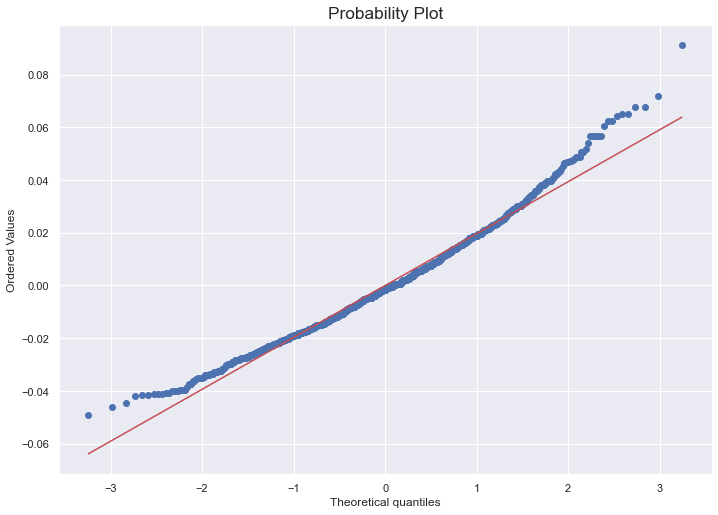

In [22]:
st.probplot(reg.resid, dist="norm", plot=plt);

L'hypothèse de normalité est remise en cause, cependant, avec le nombre d'observations que nous avons, nous pouvons nous passer de cette hypothèse.

## Test autocorrélation

In [23]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.acorr_breusch_godfrey(reg)
print('p value test Breusch godfrey:', pval)

p value test Breusch godfrey: 1.0


Non rejet de H0, absence d'autocorrélation. Maintenant que nous avons vérifier les hypothèses des MCO (hormis celle de la normalité), nous pouvons regarder le R² sur le jeu de données test.

## Test sur le jeu de données test

In [24]:
r2_score(1/model_test[["margin_low"]], reg.predict(model_test.loc[:, model_test.columns != "margin_low"]))

0.5874652697857592

Le R² est presque à 0.6. Ce résultat est correct. Nous allons utiliser notre régression linéaire pour prédire les valeurs de "margin_low".
## Prédiction des valeurs de margin_low

In [25]:
billet.loc[billet.margin_low.isna(),"margin_low"] = 1/reg.predict(billet.loc[billet.margin_low.isna(),:])

In [26]:
analyse_primaire(billet)

head()


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


dtypes


is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

shape


(1500, 7)

describe(describe = 'all')


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.481923,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.659660,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.030000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


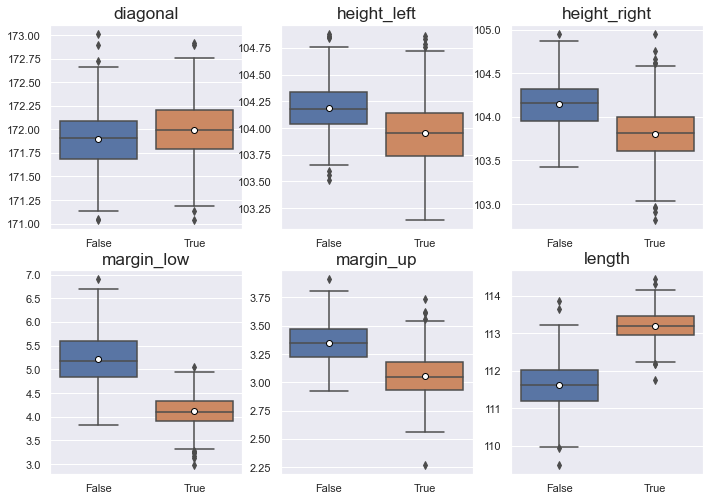

In [27]:
x=231

for i in range(billet.shape[1] - 1): #-1 car la colonne is_guenine ne doit pas passer en y
    plt.subplot(x)
    sns.boxplot(data=billet,
                    x="is_genuine", #On inverse x et y pour avoir le boxplot en horizontale.
                    y=billet.columns[i + 1],
                    showmeans = True,
                    meanprops = {"marker" : "o",
                                 "markerfacecolor" : "white",
                                 "markeredgecolor" : "black"},
                    showfliers = True);
    plt.title(billet.columns[i + 1])
    plt.xlabel("")
    plt.ylabel("")
    x += 1

L'imputation des données n'a pas modifié la distribution de "margin_low". Nous allons maintenant représenter les données grâce à une ACP.
# <a name="C4">ACP</a>

In [28]:
n_comp = 6
data_pca = billet[["diagonal", "height_left", "height_right", "margin_low", "margin_up", "length"]]

X = data_pca.values
names = data_pca.index
features = data_pca.columns

scaler_acp = preprocessing.StandardScaler()
X_scaled = scaler_acp.fit_transform(X) #centrage et réduction

pca = decomposition.PCA(n_components=n_comp)
principalComponents = pca.fit_transform(X_scaled)
pca.fit(X_scaled)

PCA(n_components=6)

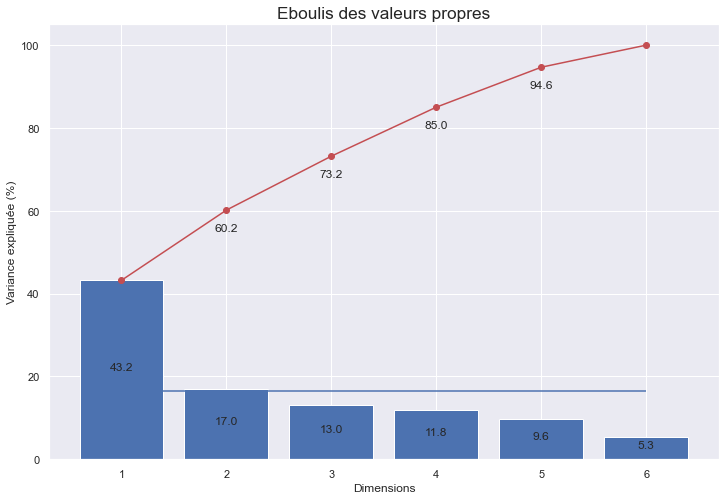

In [29]:
plt.figure(figsize=(12,8))
plt.bar(x = range(1,7), height=pca.explained_variance_ratio_*100)
plt.plot(range(1,7), np.cumsum(pca.explained_variance_ratio_*100), c ='r', marker='o')
plt.xlabel("Dimensions")
plt.ylabel("Variance expliquée (%)")

for j in range(len(pca.explained_variance_ratio_)):
    plt.annotate((pca.explained_variance_ratio_[j]*100).round(1), (j+1, pca.explained_variance_ratio_[j]*100/2), ha='center')
    if j>1 & j < len(pca.explained_variance_ratio_):
        plt.annotate(np.cumsum((pca.explained_variance_ratio_[:j]*100).round(1))[j-1],
                     (j, np.cumsum((pca.explained_variance_ratio_[:j]*100))[j-1]-5),
                     ha='center')
plt.hlines(16.6, 1, 6)
plt.title("Eboulis des valeurs propres")
plt.show()

Selon le critère de Kaiser, il ne faudrait conserver que 2 dimensions ($Var\ exp > \frac{100}{nb\ var} > 16,6\%$) cependant la variance expliquée par ces 2 dimensions ne représentent que 60%.  
La méthode du coude ne fait pas ressortir ici de "coude".  
En voulant expliqué 95% de la variance du jeu de données, nous devons conserver toutes les dimensions.  
De ce fait, nous utiliserons l'ACP juste pour représenter nos données sur un graphique à 2 dimensions:

In [30]:
comp = ["comp"+str(i) for i in range(1,7)]
finalDf = pd.concat([pd.DataFrame(data = principalComponents, columns=comp),
                     billet[["is_genuine"]]], axis = 1)

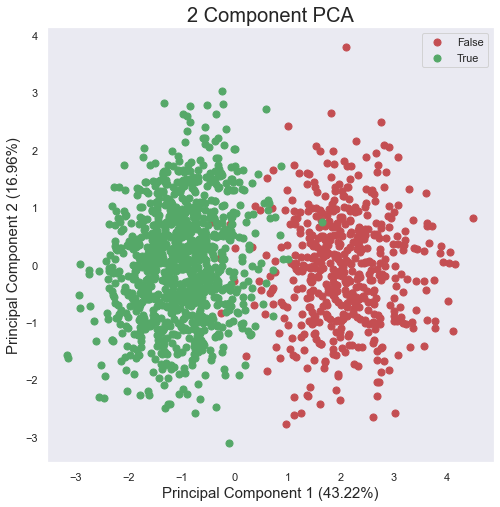

In [31]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (' + str((pca.explained_variance_ratio_[0]*100).round(2)) +'%)', fontsize = 15)
ax.set_ylabel('Principal Component 2 (' + str((pca.explained_variance_ratio_[1]*100).round(2)) +'%)', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [False, True]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_genuine'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'comp1']
               , finalDf.loc[indicesToKeep, 'comp2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

# <a name="C6">K-Means</a>

Nous allons donc effectuer K-means sur les données originales standardisées.

In [32]:
Kmeans = KMeans(n_clusters=2, random_state=42).fit(X_scaled)

print(classification_report(finalDf['is_genuine'], Kmeans.predict(X_scaled)))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98       500
        True       0.99      0.99      0.99      1000

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



K-means a réussi à obtenir de très bons résultats. Regardons cela sur les 2 premiers axes de l'ACP.

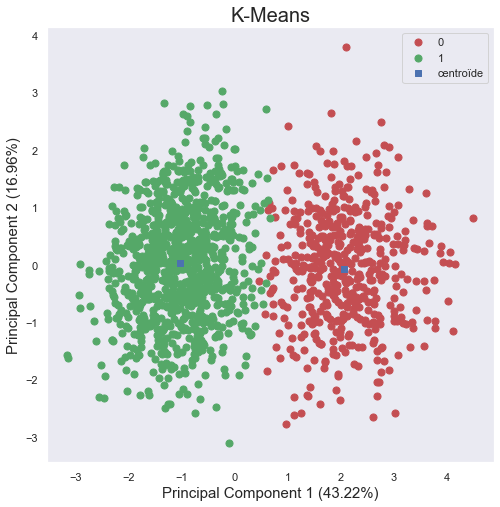

In [33]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (' + str((pca.explained_variance_ratio_[0]*100).round(2)) +'%)', fontsize = 15)
ax.set_ylabel('Principal Component 2 (' + str((pca.explained_variance_ratio_[1]*100).round(2)) +'%)', fontsize = 15)
ax.set_title('K-Means', fontsize = 20)


targets = [0, 1, "centroïde"]
colors = ['r', 'g']
for target, color in zip(targets[:2],colors):
    indicesToKeep = Kmeans.predict(X_scaled) == target
    ax.scatter(finalDf.loc[indicesToKeep, 'comp1']
               , finalDf.loc[indicesToKeep, 'comp2']
               , c = color
               , s = 50)
ax.scatter(pca.transform(Kmeans.cluster_centers_)[:,0], pca.transform(Kmeans.cluster_centers_)[:,1], marker = 's')
ax.legend(targets)
ax.grid()

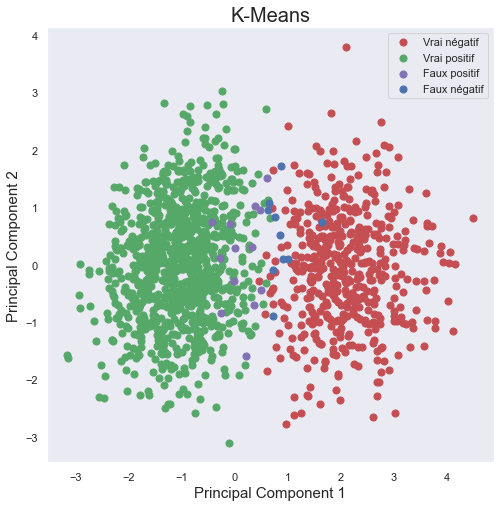

In [34]:
#Affichons les erreurs faites par K-means:
finalDf["predict"] = Kmeans.predict(X_scaled)
finalDf["res_Kmeans"] = finalDf.apply(pred, axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('K-Means', fontsize = 20)


targets = ["Vrai négatif", "Vrai positif", "Faux positif", "Faux négatif"]
colors = ['r', 'g', 'm', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf["res_Kmeans"] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'comp1']
               , finalDf.loc[indicesToKeep, 'comp2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [35]:
print("Valeurs associées aux centroïdes:")
cent = pd.DataFrame(scaler_acp.inverse_transform(Kmeans.cluster_centers_), columns = features, index = ("Faux", "Vrai"))
cent

Valeurs associées aux centroïdes:


,diagonal,height_left,height_right,margin_low,margin_up,length
Faux,171.899256,104.199759,104.151590,5.218970,3.351871,111.631630
Vrai,171.987767,103.945184,103.805703,4.116706,3.052173,113.197238


Nous pouvons regarder à quel point nos mauvaises prédictions sont éloignés de nos centroïdes:  
- Pour les faux négatifs:

In [36]:
pd.DataFrame(scaler_acp.inverse_transform(
    pca.inverse_transform(
        finalDf.loc[finalDf["res_Kmeans"] == "Faux négatif",
                    comp])), columns = features).subtract(cent.loc["Vrai"])

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.177767,0.914816,1.144297,0.403294,-0.162173,-0.367238
1,0.082233,0.384816,0.524297,0.293294,0.337827,0.192762
2,-0.087767,0.264816,0.404297,0.653294,0.327827,0.002762
3,-0.227767,0.534816,0.204297,0.233294,0.317827,-0.107238
4,-0.007767,0.494816,0.274297,0.553294,0.157827,-0.467238
5,0.152233,0.394816,0.394297,0.513294,-0.032173,-0.727238
6,0.172233,0.484816,0.254297,0.393294,0.137827,-0.507238
7,-0.047767,0.164816,0.354297,-0.036706,0.297827,-1.437238
8,0.312233,0.634816,0.364297,0.243294,0.277827,-0.217238
9,-0.357767,-0.075184,0.854297,-0.024697,0.217827,-0.517238


Pour les faux négatifs, on remarque que certains billets ont des valeurs "height_left" et "height_right" de près d'1mm supplémentaire par rapport aux centroïdes.

In [37]:
pd.DataFrame(scaler_acp.inverse_transform(
    pca.inverse_transform(
        finalDf.loc[finalDf["res_Kmeans"] == "Faux positif",
                    ["comp"+str(i) for i in range(1,7)]])), columns = features).subtract(cent.loc["Faux"])

,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.270744,0.000241,-0.02159,-1.35897,0.028129,0.80837
1,0.230744,-0.529759,-0.33159,-0.94897,-0.131871,0.51837
2,-0.079256,-0.299759,-0.48159,-0.42897,0.008129,0.79837
3,-0.049256,-0.599759,-0.33159,-0.61897,-0.141871,0.86837
4,-0.019256,-0.149759,-0.40159,-0.80897,-0.141871,0.88837
5,0.190744,-0.049759,0.01841,-1.06897,0.048129,2.21837
6,0.490744,-0.149759,0.16841,-1.08897,0.058129,1.02837
7,0.230744,-0.209759,-0.37159,0.25103,-0.411871,0.66837
8,-0.339256,-0.399759,-0.28159,0.44103,-0.371871,1.31837
9,-0.149256,-0.039759,0.00841,-0.98897,-0.361871,0.19837


Pour les faux positifs, on remarque que les variables "margin_law" et "length" ont des écarts bien plus importants par rapport aux centroïdes que les autres.

Maintenant regardons le % de bonne prédiction du modèle ainsi qu'un tableau d'association entre les prédictions et la réalité.

In [38]:
adjusted_rand_score(finalDf['is_genuine'], Kmeans.predict(X_scaled))

0.938801167612366

In [39]:
df = pd.concat([finalDf['is_genuine'], pd.DataFrame(Kmeans.predict(X_scaled), columns=["Prediction"])],axis=1)
print("Tableau d'associations des résultats de Kmeans:")
df.pivot_table(index = "is_genuine", columns = "Prediction", aggfunc = len, fill_value = 0,
               margins = True, margins_name = "total")

Tableau d'associations des résultats de Kmeans:


Prediction,0,1,total
is_genuine,,,
False,487,13,500
True,10,990,1000
total,497,1003,1500


Nous allons maintenant effectuer une régression logistique et comparer les 2 modèles.
# <a name="C5">Régression logistique</a>

In [40]:
data_X_train, data_X_test, y_train, y_test = train_test_split(data_pca, billet[["is_genuine"]], random_state = 0, test_size=0.2)

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(data_X_train)
X_test = scaler.transform(data_X_test)
print(f"Vérifions la répartition des billets:\nPour y_train:\n{y_train.value_counts()}\nLe dataset est composé de {y_train.shape[0]} valeurs.\n")
print(f"Pour y_test:\n{y_test.value_counts()}\nLe dataset est composé de {y_test.shape[0]} valeurs.")

Vérifions la répartition des billets:
Pour y_train:
is_genuine
True          797
False         403
dtype: int64
Le dataset est composé de 1200 valeurs.

Pour y_test:
is_genuine
True          203
False          97
dtype: int64
Le dataset est composé de 300 valeurs.


In [41]:
modele_regLog = linear_model.LogisticRegression(random_state = 0, solver = 'liblinear', multi_class = 'auto')

In [42]:
modele_regLog.fit(X_train,y_train.values.ravel())
y_pred = modele_regLog.predict(X_test)

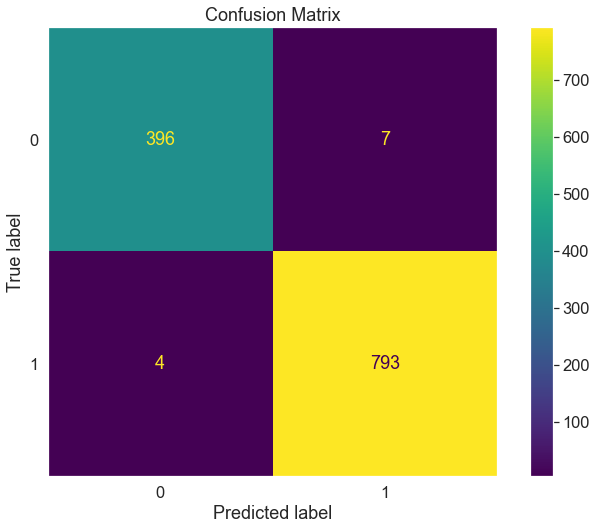

In [43]:
sns.set(font_scale=1.5)

cm = confusion_matrix(y_train, modele_regLog.predict(X_train))
ConfusionMatrixDisplay(cm).plot()
plt.grid()
plt.title("Confusion Matrix");

Nous obtenons plus de faux positifs que de faux négatifs, or notre but est de minimiser le nombre de faux positifs pour ne pas laisser passer de faux billets. Nous allons essayer de jouer sur le seuil pour avoir un meilleur résultat.
Pour ce faire nous allons maximiser la précision tout en conservant une efficacité du modèle correcte.

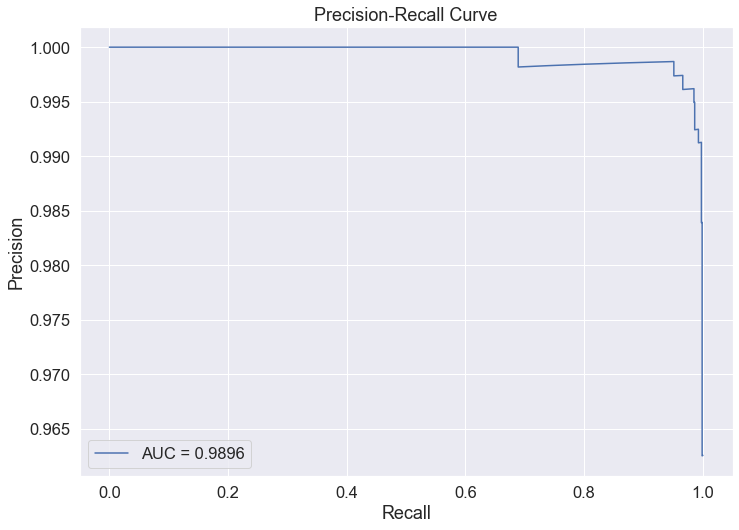

In [44]:
precision_array, recall_array, threshold_array = precision_recall_curve(
    y_true=y_train, probas_pred=modele_regLog.predict_proba(X_train)[:,1]
)

auc_pr = average_precision_score(y_true=y_train, y_score=modele_regLog.predict(X_train)) #Aire sous la courbe précision recall

plt.plot(recall_array, precision_array, label = 'AUC = %0.4f' % auc_pr)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "lower left")
plt.show()

L'AUC est très proche des 100% ce qui signifie que nous approchons d'un modèle parfait. Nous pouvons également la comparer à celui d'un modèle non-informatif qui est égale au taux de positifs soit $\frac{1000}{1500}\approx0,66$.  
Nous pouvons alors calculer un ratio de performance qui vaut l'auc_pr divisé par le taux de positivité:  
Performance du modèle = 1,48 * taux de positifs.  
Regardons plus en détail la courbe de la précision:

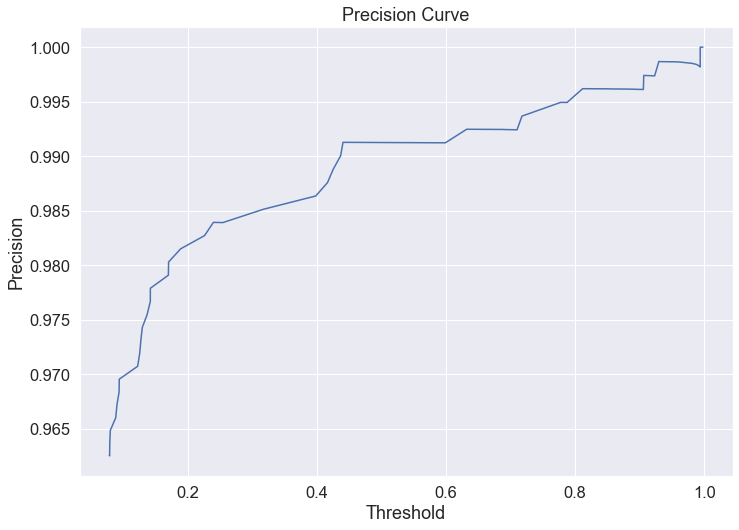

In [45]:
plt.plot(threshold_array[:400], precision_array[:400])
plt.title("Precision Curve")
plt.xlabel("Threshold")
plt.ylabel("Precision")
plt.show()

Comme attendu, la courbe de précision augmente avec le seuil. Nous pouvons voir qu'elle augmente après 0.6. Il va falloir trouver le seuil qui permet de conserver un recall correct tout en améliorant notre précision.  
Nous pouvons également regarder la courbe ROC.

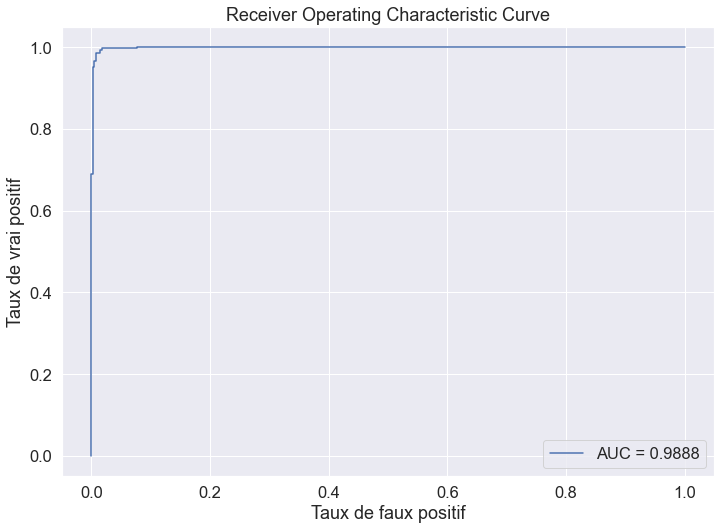

In [46]:
fpr_array, tpr_array, threshold_array = roc_curve(
    y_true=y_train, y_score=modele_regLog.predict_proba(X_train)[:,1]
)

auc_roc = roc_auc_score(y_true=y_train, y_score=modele_regLog.predict(X_train))#Aire sous la courbe

plt.plot(fpr_array, tpr_array, label = 'AUC = %0.4f' % auc_roc)
plt.title("Receiver Operating Characteristic Curve")
plt.xlabel("Taux de faux positif")
plt.ylabel("Taux de vrai positif")
plt.legend(loc = "lower right")
plt.show()

l'AUC ROC d'un modèle non informatif vaut 50% ainsi nous devons comparer notre AUC à 50%. Nous pouvons à nouveau voir que notre AUC est proche des 100%. Notre modèle est donc très bon.  
Regardons à présent l'accuracy:

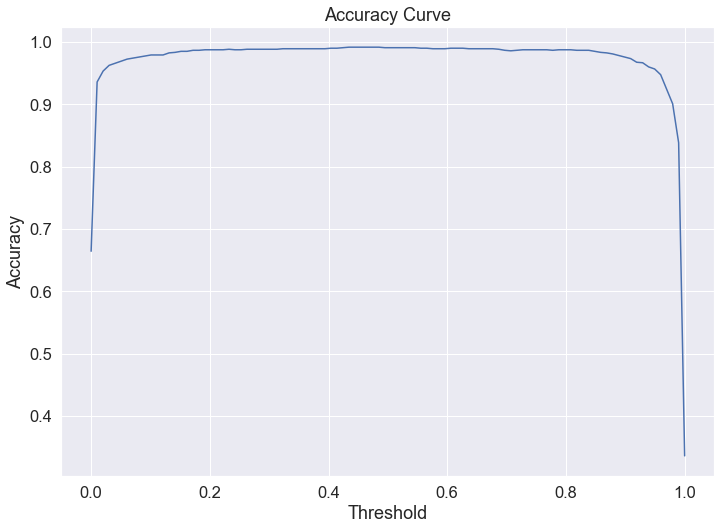

In [47]:
#Calcul de différentes métriques
threshold_array, accuracy_list, balanced_accuracy_list, f1_list, f05_list = calcul_metric(modele_regLog, X_train, y_train)

#Accuracy Curve
plt.plot(threshold_array, accuracy_list)
plt.title("Accuracy Curve")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()

In [48]:
threshold_array[np.where(accuracy_list == max(accuracy_list))]

array([0.43434343, 0.44444444, 0.45454545, 0.46464646, 0.47474747,
       0.48484848])

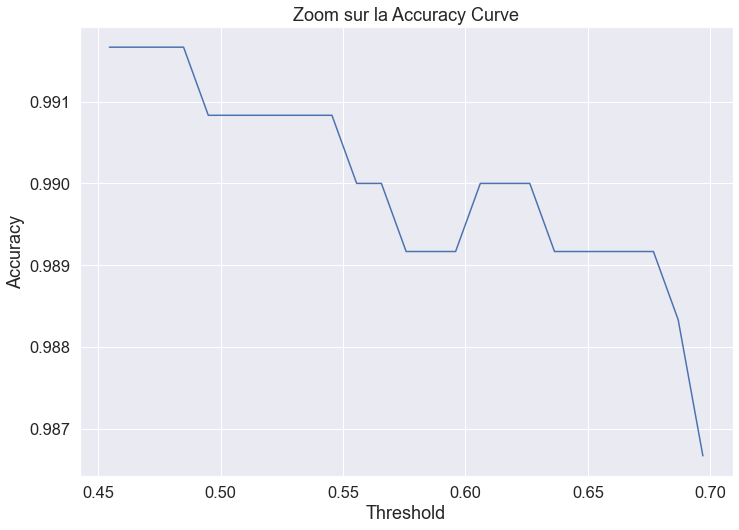

In [49]:
ranges = np.where((threshold_array>0.45) & (threshold_array<0.7))
plt.plot(threshold_array[ranges], np.array(accuracy_list)[ranges])
plt.title("Zoom sur la Accuracy Curve")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.show()

Le seuil qui minimise le nombre d'erreurs dans le modèle est compris entre 0.43 et 0.48.  
Etant donné que nous sommes en présence d'un jeu non équilibré, nous pouvons utiliser la "Balanced accuracy curve" afin de prendre en compte ce déséquilibre.

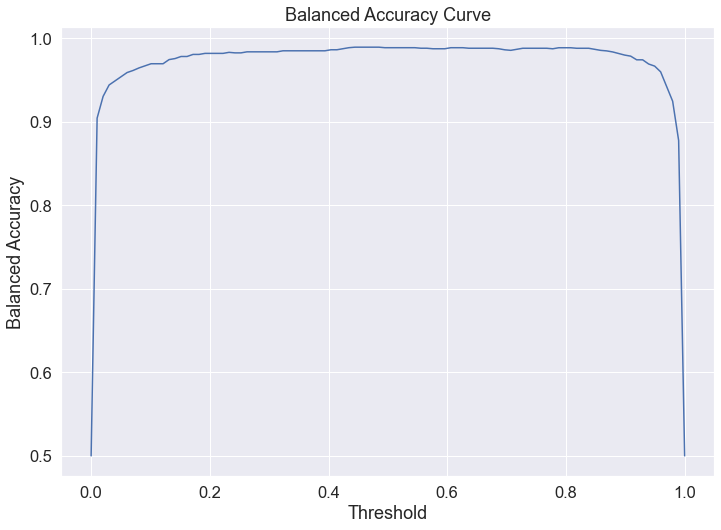

In [50]:
plt.plot(threshold_array, balanced_accuracy_list)
plt.title("Balanced Accuracy Curve")
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.show()

In [51]:
threshold_array[np.where(balanced_accuracy_list == max(balanced_accuracy_list))]

array([0.44444444, 0.45454545, 0.46464646, 0.47474747, 0.48484848])

On trouve les mêmes résultats que pour l'accuracy, le seuil qui maximise le nombre de bonnes prédictions pour notre modèle est inférieur à 50% or nous souhaitons maximiser la précision donc il nous faut augmenter le seuil. Zoomons sur la Balanced accuracy curve afin de voir ce qu'il se passe entre 0,45 et 0,7 par exemple.

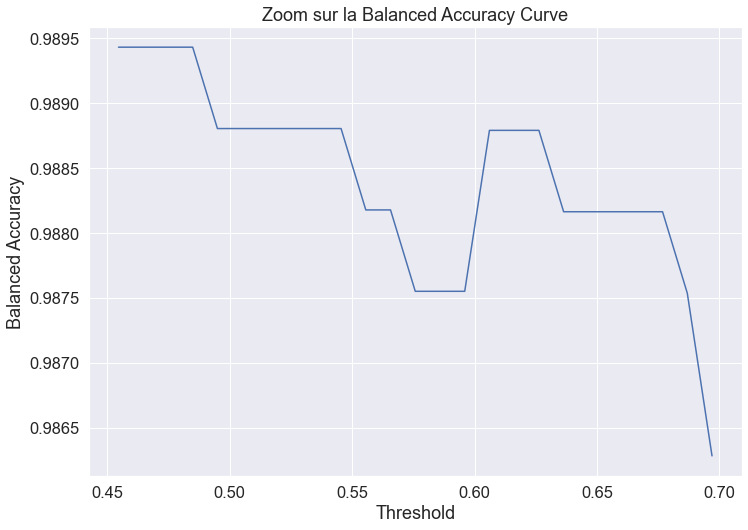

In [52]:
ranges = np.where((threshold_array>0.45) & (threshold_array<0.7))
plt.plot(threshold_array[ranges], np.array(balanced_accuracy_list)[ranges])
plt.title("Zoom sur la Balanced Accuracy Curve")
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.show()

Nous pouvons voir qu'afin de conserver un Balanced accuracy score au même niveau que le seuil de 50%, il nous faut un seuil supérieur à 60% mais inférieur à 65%.  
Nous allons maintenant regarder les F-beta score.

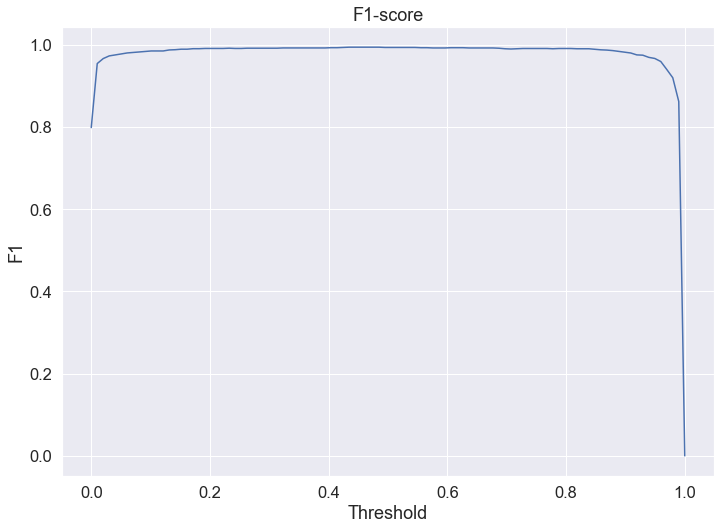

In [53]:
plt.plot(threshold_array, f1_list)
plt.title("F1-score")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.show()

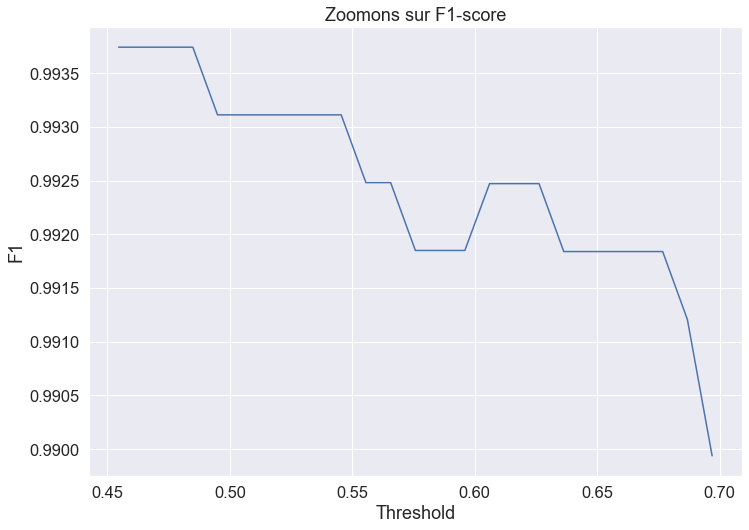

In [54]:
plt.plot(threshold_array[ranges], np.array(f1_list)[ranges])
plt.title("Zoomons sur F1-score")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.show()

Le F1-score accorde la même importance à la précision et au recall, nous allons donc regarder le F-beta score avec beta = 0.5. Cela permet de maximiser la précision.

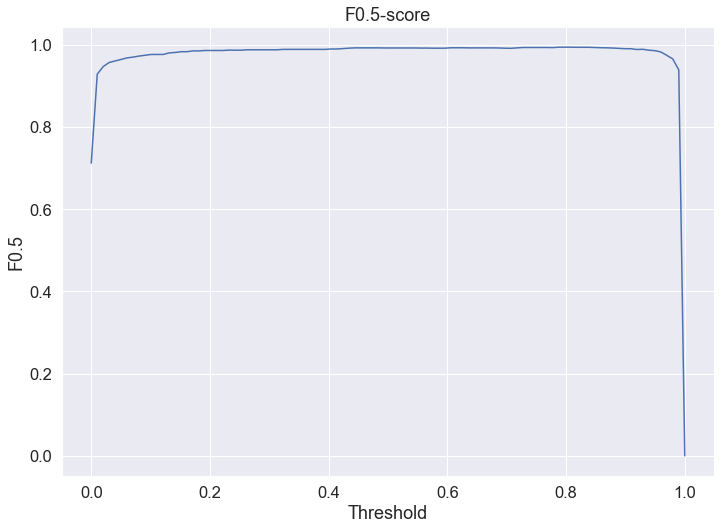

In [55]:
plt.plot(threshold_array, f05_list)
plt.title("F0.5-score")
plt.xlabel("Threshold")
plt.ylabel("F0.5")
plt.show()

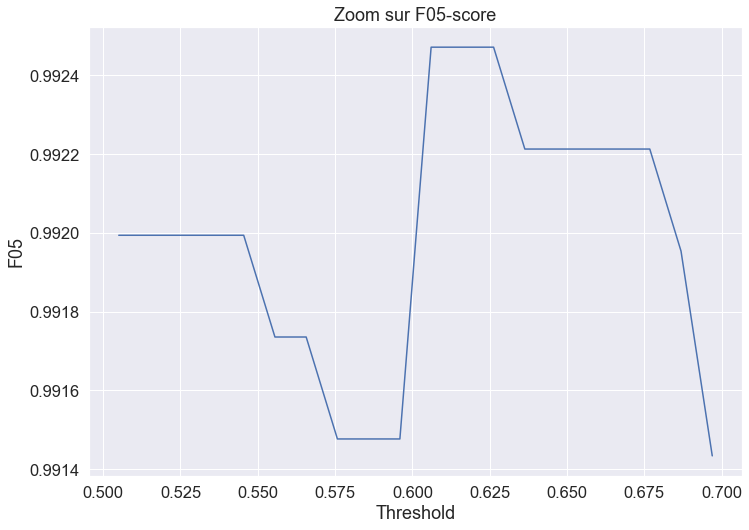

In [56]:
ranges = np.where((threshold_array>0.5) & (threshold_array<0.7))
plt.plot(threshold_array[ranges], np.array(f05_list)[ranges])
plt.title("Zoom sur F05-score")
plt.xlabel("Threshold")
plt.ylabel("F05")
plt.show()

Un seuil de 62% permet de maximiser notre F-beta score avec beta = 0.5. Nous allons donc utiliser ce seuil pour notre régression et voir l'impact sur notre jeu d'entrainement et celui de test.

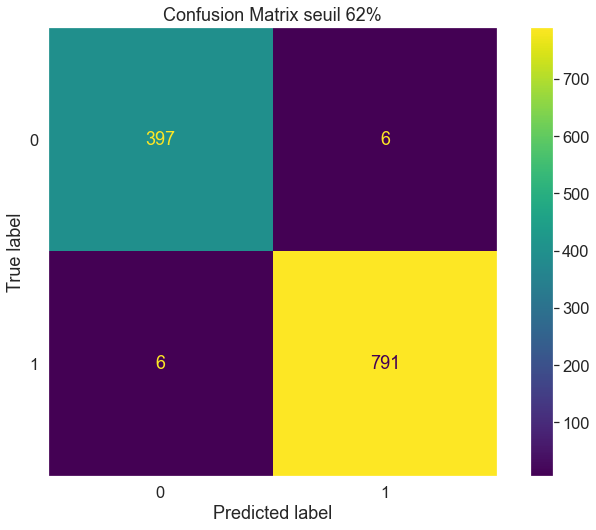

In [57]:
cm = confusion_matrix(y_train, modele_regLog.predict_proba(X_train)[:,1]>=0.62)
ConfusionMatrixDisplay(cm).plot()
plt.grid()
plt.title("Confusion Matrix seuil 62%");

Avec un seuil à 62%, nous avons 1 faux positif en moins pour 2 faux négatifs en plus. Regardons où le modèle fait des erreurs:

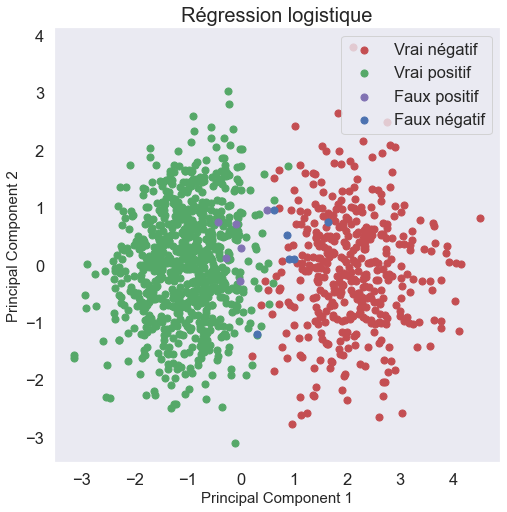

In [58]:
#Affichons les erreurs faites par la régression logistique sur le jeu d'entraînement avec un seuil à 62%:
trainDf = pd.concat([pd.DataFrame(data = pca.transform(scaler_acp.transform(data_X_train.to_numpy())), columns=comp),
                     y_train.reset_index(drop=True)], axis = 1)

trainDf["predict"] = modele_regLog.predict_proba(X_train)[:,1]>=0.62
trainDf["res_Reglog"] = trainDf.apply(pred, axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Régression logistique', fontsize = 20)


targets = ["Vrai négatif", "Vrai positif", "Faux positif", "Faux négatif"]
colors = ['r', 'g', 'm', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = trainDf["res_Reglog"] == target
    ax.scatter(trainDf.loc[indicesToKeep, 'comp1']
               , trainDf.loc[indicesToKeep, 'comp2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [59]:
mean_cm = pd.concat([pd.DataFrame(scaler_acp.inverse_transform(
    pca.inverse_transform(trainDf.loc[:,comp])), columns=features),
                     trainDf[["res_Reglog"]]], axis = 1).groupby(by="res_Reglog").mean()     

In [60]:
pd.DataFrame(scaler_acp.inverse_transform(
    pca.inverse_transform(
        trainDf.loc[trainDf["res_Reglog"] == "Faux positif",
                    comp])), columns = features).subtract(mean_cm.loc["Vrai négatif"])

,diagonal,height_left,height_right,margin_low,margin_up,length
0,0.24,-0.526751,-0.327557,-0.966237,-0.129144,0.530579
1,-0.01,-0.146751,-0.397557,-0.826237,-0.139144,0.900579
2,0.28,0.003249,-0.017557,-1.376237,0.030856,0.820579
3,0.13,-0.206751,0.132443,-1.016237,-0.369144,0.800579
4,0.20,-0.046751,0.022443,-1.086237,0.050856,2.230579
5,0.36,-0.256751,-0.467557,-1.096237,-0.099144,0.860579


Encore une fois, on remarque que "margin_law" et "length" sont les deux variables avec les plus grand écart par rapport à la moyenne de nos billets réellement négatifs.

In [61]:
pd.DataFrame(scaler_acp.inverse_transform(
    pca.inverse_transform(
        trainDf.loc[trainDf["res_Reglog"] == "Faux négatif",
                    comp])), columns = features).subtract(mean_cm.loc["Vrai positif"])

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.041618,0.165537,0.357421,-0.032541,0.30043,-1.443338
1,-0.001618,0.495537,0.277421,0.557459,0.16043,-0.473338
2,0.158382,0.395537,0.397421,0.517459,-0.02957,-0.733338
3,-0.171618,0.915537,1.147421,0.407459,-0.15957,-0.373338
4,-0.081618,0.265537,0.407421,0.657459,0.33043,-0.003338
5,-0.311618,-0.134463,-0.042579,0.477459,0.25043,-1.023338


Comme pour Kmeans, les variables "height_left" et "height_right" ont une valeur de près de 1mm suppérieur à la moyenne des autres billets.  
Nous pouvons regarder ce que donne le taux qui maximise l'accuracy:

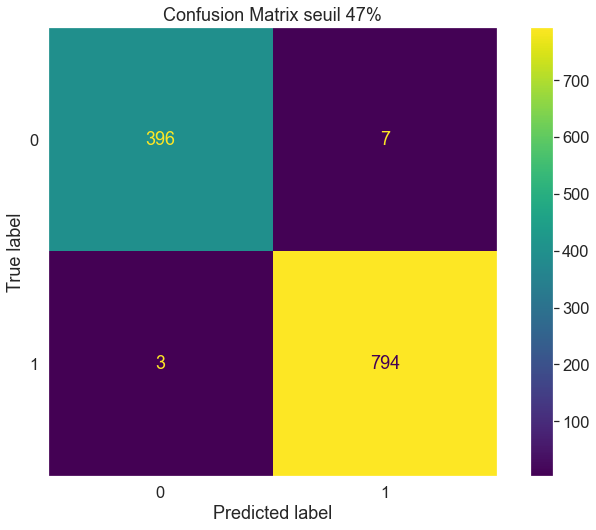

In [62]:
cm = confusion_matrix(y_train, modele_regLog.predict_proba(X_train)[:,1]>=0.47)
ConfusionMatrixDisplay(cm).plot()
plt.grid()
plt.title("Confusion Matrix seuil 47%");

Ce seuil de 47% permet d'obtenir le même nombre de faux positif qu'un seuil de 50% mais un faux négatif de moins.
Le changement est très faible. 
## Prédiction sur le jeu de test

Seuil à 50%:


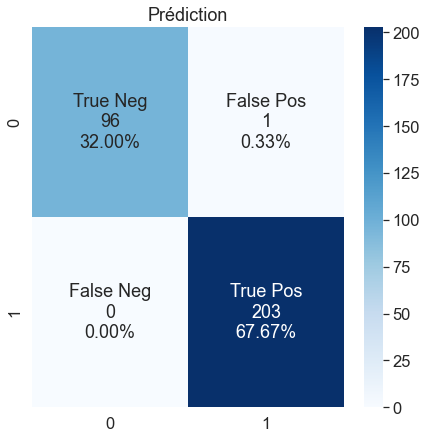

In [63]:
cm = confusion_matrix(y_test, y_pred)
print("Seuil à 50%:")
plot_confusion_matrix(cm)

Seuil à 62%:


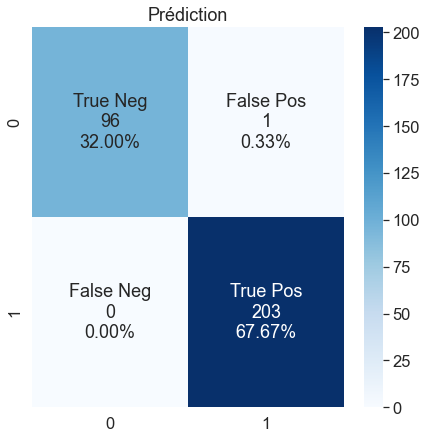

In [64]:
cm = confusion_matrix(y_test, modele_regLog.predict_proba(X_test)[:,1]>=0.62)
print("Seuil à 62%:")
plot_confusion_matrix(cm)

In [65]:
df = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(modele_regLog.predict_proba(X_test)[:,1]>=0.62, columns=["Prediction"])],axis=1)
df.pivot_table(index = "is_genuine", columns = "Prediction", aggfunc = len, fill_value = 0,
               margins = True, margins_name = "total")

Prediction,False,True,total
is_genuine,,,
False,96,1,97
True,0,203,203
total,96,204,300


Nous pouvons à nouveau afficher nos erreurs:

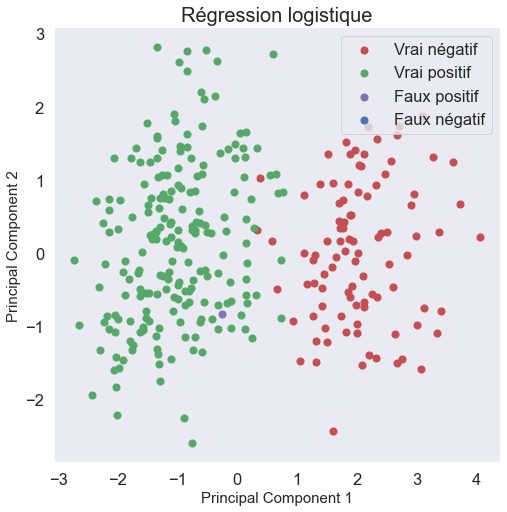

In [66]:
#Affichons les erreurs faites par la régression logistique sur le jeu d'entraînement avec un seuil à 62%:
testDf = pd.concat([pd.DataFrame(data = pca.transform(scaler_acp.transform(data_X_test.to_numpy())), columns=["comp"+str(i) for i in range(1,7)]),
                     y_test.reset_index(drop=True)], axis = 1)

testDf["predict"] = modele_regLog.predict_proba(X_test)[:,1]>=0.62
testDf["res_Reglog"] = testDf.apply(pred, axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Régression logistique', fontsize = 20)


targets = ["Vrai négatif", "Vrai positif", "Faux positif", "Faux négatif"]
colors = ['r', 'g', 'm', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = testDf["res_Reglog"] == target
    ax.scatter(testDf.loc[indicesToKeep, 'comp1']
               , testDf.loc[indicesToKeep, 'comp2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [67]:
print(classification_report(y_test, modele_regLog.predict_proba(X_test)[:,1]>=0.62, digits=3)[:220])

              precision    recall  f1-score   support

       False      1.000     0.990     0.995        97
        True      0.995     1.000     0.998       203

    accuracy                          0.997       300
  


Nos prédictions sont très bonnes, nous obtenons 1 faux positifs et 0 faux négatif. Avec un seuil de 50 ou 62%, nous obtenons les mêmes scores. Nous allons conserver un seuil de 62% pour notre modèle.  
## Comparons avec K-means

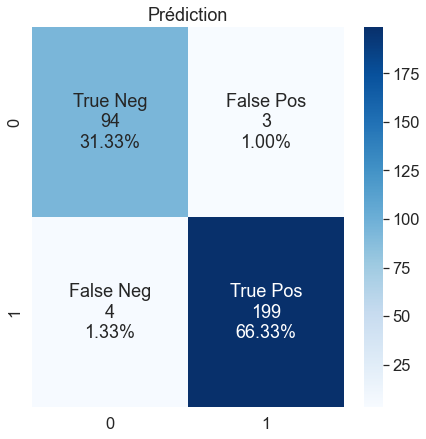

In [68]:
X_test_Kmeans = scaler_acp.transform(data_X_test.values) #centrage et réduction avec les mêmes valeurs que l'ACP.

cm2 = confusion_matrix(y_test, Kmeans.predict(X_test_Kmeans))
plot_confusion_matrix(cm2)

On peut voir que la régression logistique permet une meilleure prédiction que l'algorithme de Kmeans. Nous utiliserons donc la régression logistique pour effectuer les prédictions pour la suite.

# Prédiction

In [69]:
data_test = pd.read_csv('billets_production.csv', sep=",", decimal=".")
data_index = data_test.id

In [70]:
data_test = scaler.transform(data_test.loc[:,data_test.columns != "id"])

In [71]:
modele_regLog.predict_proba(data_test)[:,1]>=0.62

array([False, False, False,  True,  True])

In [72]:
joblib.dump(modele_regLog, "backend\modele.pkl")
joblib.dump(scaler, "backend\scaler.pkl")

['backend\\scaler.pkl']